<a href="https://colab.research.google.com/github/JonSax88/PracticalMachineLearning/blob/main/Sax_Module3Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingest

In [ ]:
import pandas as pd
from pandas import Categorical 
import numpy as np
from pathlib import Path  
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge, RidgeCV

%matplotlib inline
sns.set()

In [ ]:
df_train = pd.read_csv("/content/train.csv")

In [156]:
df_test = pd.read_csv("/content/test.csv")

# EDA


**Management/Research Question:**

How do we use the following four variables from the training set vs. the training set's Sale Prices, to create predictions of the test set's expected Sale Prices?

- GrLivArea (living area square feet, above grade)
- 2ndFlrSF (2nd floor square footage)
- OverallQual (Overall Quality)
- OpenPorchSF (open porch area in square feet)

In [ ]:
# select subset of training data
data = df_train[["GrLivArea", "2ndFlrSF", "OverallQual", "OpenPorchSF", "SalePrice"]]
data.head()

,GrLivArea,2ndFlrSF,OverallQual,OpenPorchSF,SalePrice
0,1710,854,7,61,208500
1,1262,0,6,0,181500
2,1786,866,7,42,223500
3,1717,756,7,35,140000
4,2198,1053,8,84,250000


Let's take a look at each of the four predictors' histograms and scatterplots (or stripplots, depending on appropriateness) vs. Sale Price.

Text(0.5, 1.0, 'Scatterplot')

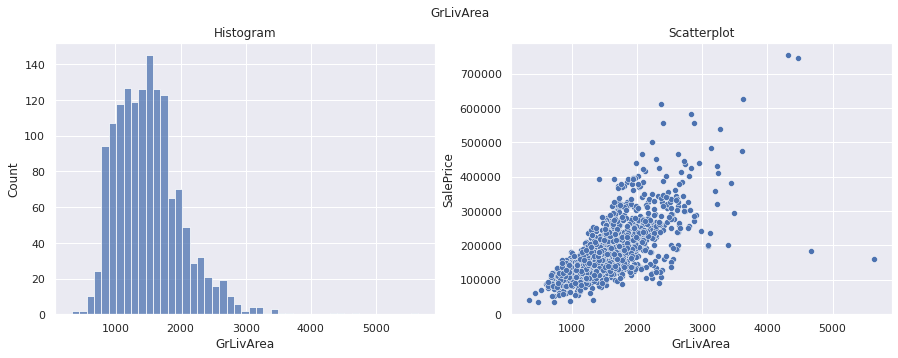

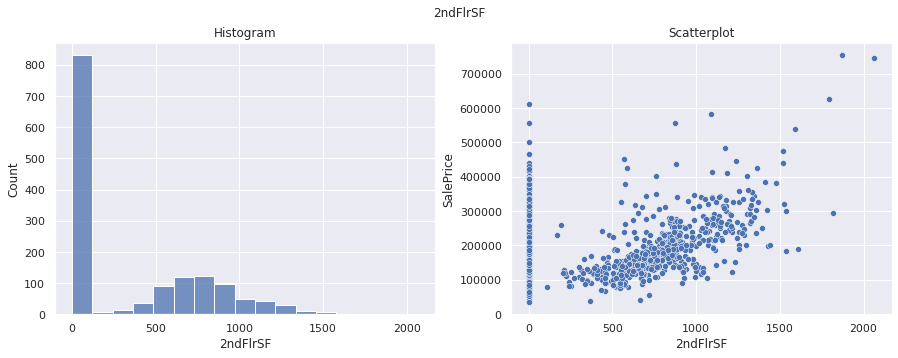

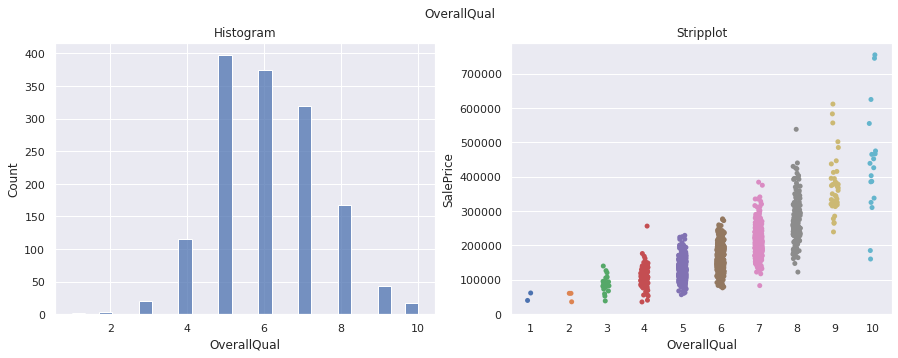

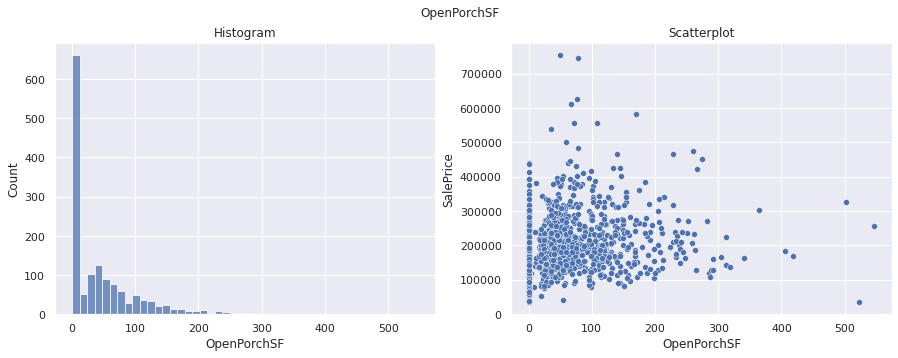

In [ ]:
# GrLivArea

fig, axes = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle('GrLivArea')

sns.histplot(data=data, ax=axes[0], x='GrLivArea')
axes[0].set_title('Histogram')

sns.scatterplot(data=data, ax=axes[1], x='GrLivArea', y='SalePrice')
axes[1].set_title('Scatterplot')

# 2ndFlrSF

fig, axes = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle('2ndFlrSF')

sns.histplot(data=data, ax=axes[0], x='2ndFlrSF')
axes[0].set_title('Histogram')

sns.scatterplot(data=data, ax=axes[1], x='2ndFlrSF', y='SalePrice')
axes[1].set_title('Scatterplot')

# OverallQual

fig, axes = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle('OverallQual')

sns.histplot(data=df_train, ax=axes[0], x='OverallQual')
axes[0].set_title('Histogram')

sns.stripplot(data=df_train, ax=axes[1], x='OverallQual', y='SalePrice')
axes[1].set_title('Stripplot')

# OpenPorchSF

fig, axes = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle('OpenPorchSF')

sns.histplot(data=data, ax=axes[0], x='OpenPorchSF')
axes[0].set_title('Histogram')

sns.scatterplot(data=data, ax=axes[1], x='OpenPorchSF', y='SalePrice')
axes[1].set_title('Scatterplot')

It appears that GrLivArea follows a relatively normal distribution, while 2ndFlrSF, Fireplaces and OpenPorchSF are heavily skewed. I'm going to apply the skew() function to logarithmically transform any features with a skew greater than 0.5.

In [ ]:
# Normalizing all columns with absolute value of skew greater than 0.5

skewcols = data.skew(axis = 0).sort_values(ascending=False)
high_skew = skewcols[abs(skewcols > 0.5)]
high_skew.index
data[high_skew.index] = np.log1p(data[high_skew.index])

data

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,GrLivArea,2ndFlrSF,OverallQual,OpenPorchSF,SalePrice
0,7.444833,6.751101,7,4.127134,12.247699
1,7.141245,0.000000,6,0.000000,12.109016
2,7.488294,6.765039,7,3.761200,12.317171
3,7.448916,6.629363,7,3.583519,11.849405
4,7.695758,6.960348,8,4.442651,12.429220
...,...,...,...,...,...
1455,7.407318,6.543912,6,3.713572,12.072547
1456,7.637234,0.000000,6,0.000000,12.254868
1457,7.758333,7.050123,7,4.110874,12.493133
1458,6.983790,0.000000,5,0.000000,11.864469


In [ ]:
# I'm going to un-scale my y (SalePrice) so that my model does not predict
# scaled results on the test set

SalePriceTrain = df_train[['SalePrice']]
data['SalePrice'] = SalePriceTrain
data

,GrLivArea,2ndFlrSF,OverallQual,OpenPorchSF,SalePrice
0,7.444833,6.751101,7,4.127134,208500
1,7.141245,0.000000,6,0.000000,181500
2,7.488294,6.765039,7,3.761200,223500
3,7.448916,6.629363,7,3.583519,140000
4,7.695758,6.960348,8,4.442651,250000
...,...,...,...,...,...
1455,7.407318,6.543912,6,3.713572,175000
1456,7.637234,0.000000,6,0.000000,210000
1457,7.758333,7.050123,7,4.110874,266500
1458,6.983790,0.000000,5,0.000000,142125


# Modeling

Now I will peform Lasso, Ridge, and ElasticNet regression on my newly standardized dataset. Whichever method yields the best R^2 on my training set, I will use to create predictions on our test set.

*Regression Model 1: Lasso*

In [ ]:
# define predictor and response variables, after they've been skew() scaled
X = data[["GrLivArea", "2ndFlrSF", "OverallQual", "OpenPorchSF"]]
y = data["SalePrice"]

# Make a list of all numerical features

list_numerical = data.columns 
list_numerical

Index(['GrLivArea', '2ndFlrSF', 'OverallQual', 'OpenPorchSF', 'SalePrice'], dtype='object')

In [ ]:
# Lasso Regression

reg = Lasso(alpha=10)
reg.fit(X, y)

Lasso(alpha=10)

In [ ]:
# Model evaluation

print('R squared training set', round(reg.score(X, y)*100, 2))

# Training data
pred_train = reg.predict(X)
mse_train = mean_squared_error(y, pred_train)
print('MSE training set', round(mse_train, 2))

R squared training set 72.58
MSE training set 1729301835.72


In [ ]:
# K-fold cross validation

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=100000)

# Fit model
model.fit(X, y)

LassoCV(cv=5, max_iter=100000, random_state=0)

In [ ]:
# Show best value of penalization chosen by cross validation:

model.alpha_

print('R squared training set', round(model.score(X, y)*100, 2))

R squared training set 72.58


*Regression Model 2: Ridge*

In [ ]:
# Ridge Regression

model2 = Ridge(alpha=10)
model2.fit(X, y)

Ridge(alpha=10)

In [ ]:
#define cross-validation method to evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#define model
model2 = RidgeCV(cv=cv, scoring='neg_mean_absolute_error')

#fit model
model2.fit(X, y)

#display lambda that produced the lowest test MSE
print(model2.alpha_)

10.0


In [ ]:
# Model evaluation

print('R squared training set', round(model2.score(X, y)*100, 2))

# Training data
pred_train = model2.predict(X)
mse_train = mean_squared_error(y, pred_train)
print('MSE training set', round(mse_train, 2))

R squared training set 72.43
MSE training set 1738521592.37


*Regression Model 3: ElasticNet*

I am selecting an r = 0.5 so that the model is a true 50% mix of Lasso and Ridge regression.

In [ ]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.5)
elastic_net.fit(X, y)

ElasticNet(alpha=0.01)

In [ ]:
# Model evaluation

print('R squared training set', round(elastic_net.score(X, y)*100, 2))

# Training data
pred_train = elastic_net.predict(X)
mse_train = mean_squared_error(y, pred_train)
print('MSE training set', round(mse_train, 2))

R squared training set 72.5
MSE training set 1734579885.52


My R squareds for all three of these weren't very high, ~72. Now I'm going to try the same 3x regressions, but instead of using the skew() function, I'm going to use the StandardScaler, to check if that helps.  

In [ ]:
# select subset of training data

data1 = df_train[["GrLivArea", "2ndFlrSF", "OverallQual", "OpenPorchSF", "SalePrice"]]
data1.head()

,GrLivArea,2ndFlrSF,OverallQual,OpenPorchSF,SalePrice
0,1710,854,7,61,208500
1,1262,0,6,0,181500
2,1786,866,7,42,223500
3,1717,756,7,35,140000
4,2198,1053,8,84,250000


In [ ]:
# Make a list of all numerical features

list_numerical1 = data1.columns 
list_numerical1

# Standardization

scaler = StandardScaler().fit(data1[list_numerical1]) 
data1[list_numerical1] = scaler.transform(data1[list_numerical1])
data1

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,GrLivArea,2ndFlrSF,OverallQual,OpenPorchSF,SalePrice
0,0.370333,1.161852,0.651479,0.216503,0.347273
1,-0.482512,-0.795163,-0.071836,-0.704483,0.007288
2,0.515013,1.189351,0.651479,-0.070361,0.536154
3,0.383659,0.937276,0.651479,-0.176048,-0.515281
4,1.299326,1.617877,1.374795,0.563760,0.869843
...,...,...,...,...,...
1455,0.250402,0.795198,-0.071836,-0.100558,-0.074560
1456,1.061367,-0.795163,-0.071836,-0.704483,0.366161
1457,1.569647,1.844744,0.651479,0.201405,1.077611
1458,-0.832788,-0.795163,-0.795151,-0.704483,-0.488523


In [ ]:
# make sure the y isn't scaled (again)

data1['SalePrice'] = SalePriceTrain

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


*Regression Model 1: Lasso*

(using standardscaler)

In [ ]:
# define predictor and response variables
X1 = data1[["GrLivArea", "2ndFlrSF", "OverallQual", "OpenPorchSF"]]
y1 = data1["SalePrice"]


In [ ]:
# Lasso Regression

reg1 = Lasso(alpha=1, fit_intercept=False)
reg1.fit(X1, y1)

Lasso(alpha=1, fit_intercept=False)

In [ ]:
# Model evaluation

print('R squared training set', round(reg1.score(X1, y1)*100, 2))

# Training data
pred_train = reg1.predict(X1)
mse_train = mean_squared_error(y1, pred_train)
print('MSE training set', round(mse_train, 2))

R squared training set -445.44
MSE training set 34399467059.61


*Regression Model 2: Ridge*

(using standardscaler)

In [ ]:
# Ridge Regression

ridgestandard = Ridge(alpha=10)
ridgestandard.fit(X1, y1)

Ridge(alpha=10)

In [ ]:
#define cross-validation method to evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#define model
ridgestandard = RidgeCV(cv=cv, scoring='neg_mean_absolute_error')

#fit model
ridgestandard.fit(X1, y1)

#display lambda that produced the lowest test MSE
print(ridgestandard.alpha_)

10.0


In [ ]:
# Model evaluation

print('R squared training set', round(ridgestandard.score(X1, y1)*100, 2))

# Training data
pred_train = ridgestandard.predict(X1)
mse_train = mean_squared_error(y1, pred_train)
print('MSE training set', round(mse_train, 2))

R squared training set 73.56
MSE training set 1667256762.73


*Regression Model 3: ElasticNet*

(using standardscaler)

In [ ]:
elastic_net2 = ElasticNet(alpha=.01, l1_ratio=0.5)
elastic_net2.fit(X1, y1)

ElasticNet(alpha=0.01)

In [ ]:
# Model evaluation

print('R squared training set', round(elastic_net2.score(X1, y1)*100, 2))

# Training data
pred_train = elastic_net2.predict(X1)
mse_train = mean_squared_error(y1, pred_train)
print('MSE training set', round(mse_train, 2))

R squared training set 73.57
MSE training set 1667132617.85


Switching from the skew() scaling to the StandardScaler only increased my R^2 by one percentile, to 73.5.

# Prediction 1

I'm going to use the ElasticNet model (with skew scaling) as my first model to use on the test set.

In [ ]:
# define new observation

newdata = df_test[["GrLivArea", "2ndFlrSF", "OverallQual", "OpenPorchSF"]]
newdata

newdata.head(50)

,GrLivArea,2ndFlrSF,OverallQual,OpenPorchSF
0,896,0,5,0
1,1329,0,6,36
2,1629,701,5,34
3,1604,678,6,36
4,1280,0,8,82
5,1655,892,6,84
6,1187,0,6,21
7,1465,676,6,75
8,1341,0,7,0
9,882,0,4,0


In [ ]:
# Run skew () on the newdata dataframe
# Normalizing all columns with absolute value of skew greater than 0.5

skewcols = newdata.skew(axis = 0).sort_values(ascending=False)
high_skew = skewcols[abs(skewcols > 0.5)]
high_skew.index
newdata[high_skew.index] = np.log1p(newdata[high_skew.index])

newdata

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,GrLivArea,2ndFlrSF,OverallQual,OpenPorchSF
0,6.799056,0.000000,5,0.000000
1,7.192934,0.000000,6,3.610918
2,7.396335,6.553933,5,3.555348
3,7.380879,6.520621,6,3.610918
4,7.155396,0.000000,8,4.418841
...,...,...,...,...
1454,6.996681,6.304449,4,0.000000
1455,6.996681,6.304449,4,3.218876
1456,7.110696,0.000000,5,0.000000
1457,6.878326,0.000000,5,3.496508


In [ ]:
# Run the predictive model

prediction = elastic_net.predict(newdata)
print(prediction)



[107424.75710089 185516.75666199 145546.66273863 ... 139178.38726551
 122167.25810641 227617.77772367]


In [ ]:
prediction2 = pd.DataFrame(prediction, columns = ['SalePrice'])
prediction2

,SalePrice
0,107424.757101
1,185516.756662
2,145546.662739
3,175303.142556
4,245382.909280
...,...
1454,68095.605320
1455,74231.815454
1456,139178.387266
1457,122167.258106


In [ ]:
iddf = pd.DataFrame(df_test, columns = ['Id', 'OverallQual'])
iddf = iddf.dropna()
iddf = iddf.drop(['OverallQual'], axis=1)
iddf

result = pd.concat([iddf, prediction2], axis =1, join='inner')
display(result)

,Id,SalePrice
0,1461,107424.757101
1,1462,185516.756662
2,1463,145546.662739
3,1464,175303.142556
4,1465,245382.909280
...,...,...
1454,2915,68095.605320
1455,2916,74231.815454
1456,2917,139178.387266
1457,2918,122167.258106


# Prediction 2

Now I'm going to use my Ridge regression model with StandardScaler on the test set.

In [ ]:
# Make a list of all numerical features

list_numerical2 = newdata.columns 
list_numerical2

# Standardization

scaler = StandardScaler().fit(newdata[list_numerical2]) 
newdata[list_numerical2] = scaler.transform(newdata[list_numerical2])
newdata

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,GrLivArea,2ndFlrSF,OverallQual,OpenPorchSF
0,-1.442112,-0.857154,-0.751101,-1.093550
1,-0.194908,-0.857154,-0.054877,0.581419
2,0.449155,1.153084,-0.751101,0.555642
3,0.400213,1.142867,-0.054877,0.581419
4,-0.313771,-0.857154,1.337571,0.956184
...,...,...,...,...
1454,-0.816336,1.076562,-1.447325,-1.093550
1455,-0.816336,1.076562,-1.447325,0.399565
1456,-0.455313,-0.857154,-0.751101,-1.093550
1457,-1.191104,-0.857154,-0.751101,0.528348


In [ ]:
# Ridge Prediction

RidgePrediction = ridgestandard.predict(newdata)
print(RidgePrediction)


[101414.31661937 184993.3764051  150583.10549744 ... 142034.31186901
 114501.87161678 234642.69281586]


In [ ]:
# Returning to a dataframe and adding Id

prediction3 = pd.DataFrame(RidgePrediction, columns = ['SalePrice'])
prediction3

,SalePrice
0,101414.316619
1,184993.376405
2,150583.105497
3,178166.875354
4,239526.352857
...,...
1454,67493.520053
1455,70029.968246
1456,142034.311869
1457,114501.871617


In [ ]:
iddf2 = pd.DataFrame(df_test, columns = ['Id', 'OverallQual'])
iddf2 = iddf2.dropna()
iddf2 = iddf2.drop(['OverallQual'], axis=1)
iddf2


,Id
0,1461
1,1462
2,1463
3,1464
4,1465
...,...
1454,2915
1455,2916
1456,2917
1457,2918


In [ ]:
result2 = pd.concat([iddf2, prediction3], axis =1, join='inner')
display(result2)


,Id,SalePrice
0,1461,101414.316619
1,1462,184993.376405
2,1463,150583.105497
3,1464,178166.875354
4,1465,239526.352857
...,...,...
1454,2915,67493.520053
1455,2916,70029.968246
1456,2917,142034.311869
1457,2918,114501.871617


In [ ]:
result2.to_csv(index=False)
filepath = Path("/content/result2.csv")
filepath.parent.mkdir(parents=True, exist_ok=True)
result2.to_csv(filepath)

In [ ]:
result.to_csv(index=False)
filepath = Path("/content/result.csv")
filepath.parent.mkdir(parents=True, exist_ok=True)
result.to_csv(filepath)

# Conclusion

Both of my Kaggle submissions did not perform well, having scores of 0.87 and 0.93. I am fairly certain that they did not do well relative to other submissions because I only used four variables in my model. For future models, I am going to incorporate many more variables.

I am also going to use pipeplines next time so that I can regularize my training set and train it with a regression technique at the same time. This will save me several lines of code. I will also use an Imputer so that I do not have any null rows when creating my prediction.
